In [17]:
import grasshopper.interferometers as ifo
import astropy.units as u
import astropy.constants as c
import numpy as np

In [25]:
import thesis

In [18]:
torr = 101325/760 * u.pascal

In [19]:
class AdvancedDetector(ifo.AdvancedLIGO):
    residual_gas_pressure = 3e-6 * torr
    temperature = 300 * u.Kelvin
    residual_gas_mass = 2 * u.u
    
    properties = {
            'infrastructure': {
                'arms': {
                    'number': 2,
                    'finesse': 450,
                },
                'residual_gas': {
                    'pressure': 3e-6 * torr,
                    'mass': 2 * u.u,
                    'polarizability': 7.8e-31 *u.meter**3
            }
        },
            'suspension': {
                'resonant_frequency': 0.75 * u.hertz,
                'stacks_no': 4,
        },
        
            'laser':  {
                'wavelength': 1064 * u.nanometer,
                'type': "Nd:YAG"
        },
            'optics': {
                'curvature': {
                    'ITM': 1934 * u.meter,
                    'ETM': 2245 * u.meter
                }
            }
        }
    
    def psd_seismic(self, frequency):
        """
        Calculate the seismic noise for the interferometer.
        
        Parameters
        ----------
        frequency : float
            The frequency at which the PSD should be evaluated.
        """
        s_ground = 1e-18 * u.meter**2 / u.hertz * (10*u.hertz / frequency)**4
        f_pen = self.properties['suspension']['resonant_frequency']
        
        return self.length**2 * s_ground * (f_pen / frequency)**4
    
    def residual_gas(self, frequency):
        """
        Calculate the noise spectrum due to residual gas in the interferometer.

        Parameters
        ----------
        frequency : float
            The frequency at which the PSD should be evaluated.

        Returns
        -------
        psd : float
            The power spectral density due to residual gas at the frequency.

        Notes
        -----
        This method is based off the implementation of gas noise from the GWINC
        Matlab package. That function was itself based of the LIGO document
            Optical Pathlength Noise in Sensitive Interferometers Due to Residual Gas.
        See DCC P940008-00
        """
        
        number_density = self.properties['infrastructure']['residual_gas']['pressure'] / (c.k_B * self.temperature)
        gas_velocity = np.sqrt(2*c.k_B*self.temperature / self.properties['infrastructure']['residual_gas']['mass'])
        
        # The g resonators of the test masses
        g1 = 1 - self.length / self.properties['optics']['curvature']['ITM']
        g2 = 1 - self.length / self.properties['optics']['curvature']['ETM']
        
        # The beam waist size
        waist = self.length * self.properties['laser']['wavelength']
        waist *= np.sqrt(((g1*g2)*(1-g1*g2)) / (g1+g2-2*g1*g2)**2)
        waist = np.sqrt(waist)
        
        # The Rayleigh range
        rayleigh = (np.pi * waist**2 / self.properties['laser']['wavelength']).to(u.meter)
        
        # ITM location relative to the waist
        z_itm = (- (( g2*(1-g1) ) / (g1+g2 - 2*g1*g2))*self.length).to(u.meter)
        z_etm = ((( g1*(1-g2) ) / (g1+g2 - 2*g1*g2))*self.length).to(u.meter)
        
        # Take the first-order expansion of the integral to avoid
        # the need for numerical integration.
        z_int = np.log(z_etm.value + np.sqrt(z_etm**2 + rayleigh**2).value)
        z_int -= np.log(z_itm.value + np.sqrt(z_itm**2 + rayleigh**2).value)
        z_int *= rayleigh / waist
        z_int = z_int - 2*np.pi*self.length*frequency / gas_velocity
        #print z_int
        # Calculate the path length for a single arm
        z_int *= ( (4*number_density*(2*np.pi*self.properties['infrastructure']['residual_gas']['polarizability'])**2)/gas_velocity)
        z_int[z_int < 0] = 0
        psd = self.properties['infrastructure']['arms']['number'] * z_int / self.length**2
        return np.sqrt(psd).decompose()

In [29]:
aligo = AdvancedDetector()

In [30]:
import matplotlib.pyplot as plt
#plt.style.use('/home/daniel/papers/thesis/thesis-style.mpl')
%matplotlib inline

In [31]:
frequencies = np.logspace(0, 4, 1000)*u.hertz

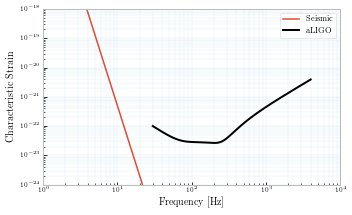

In [32]:
fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
#ax.plot(frequencies, test.residual_gas(frequencies), label='Res. Gas')
ax.loglog(frequencies, test.psd_seismic(frequencies), label='Seismic')
test.plot(ax, color='k')
ax.set_xlim([1e-0, 1e4])
ax.set_ylim([1e-24, 1e-18])
ax.legend()
thesis.thesisify(fig);
#fig.savefig("/home/daniel/papers/thesis/figures/seismicnoise-psd.pdf")

In [1]:
import lalsimulation

In [9]:
import numpy as np

In [34]:
lalsimulation.SimNoisePSDQuantum?

f	frequency (Hz)
I0	laser power (W)
lambda	laser wavelength (m)
L	arm length (m)
M	mirror mass (kg)
A	average per mirror power loss
A_BS	power loss at beam splitter
T_ITM	transmittance of ITM
T_PRM	transmittance of PRM
T_SRM	transmittance of SRM
ds	detuning phase (rad)
zeta	demod/detection/homodyne phase
eta	quantum efficiency of photodiode 

In [36]:
power = 70
wavelength = 1064
arm_length = 4000
mirror_mass = 40
power_loss = 0.01
bs_loss = 0.1
itm_trans = 0.97
prm_trans = 0.97
srm_trans = 0.97
detune = 0.01
homodyne_phase = 0
diode_efficiency = 0.99

quantum = map(lambda f: lalsimulation.SimNoisePSDQuantum(f, 
                                                         power, 
                                                         wavelength,
                                                         arm_length,
                                                         mirror_mass,
                                                         power_loss,
                                                         bs_loss, 
                                                         itm_trans,
                                                         prm_trans,
                                                         srm_trans,
                                                         detune,
                                                         homodyne_phase,
                                                         diode_efficiency
                                                        ), np.logspace(1,4,1000))

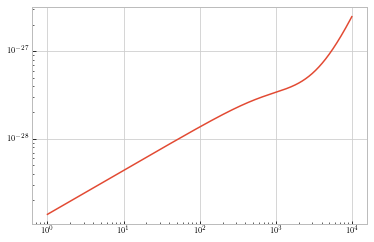

In [41]:
f = np.logspace(0,4,1000)
plt.loglog(f, np.sqrt(f)*quantum)

In [202]:
import lalburst

In [203]:
?lalburst.DestroySimBurst

In [204]:
?lalburst.GenerateSimBurst

In [205]:
import lal

In [206]:
lal.DestroyREAL8Sequence

<function _lal.DestroyREAL8Sequence>

In [208]:
c = np.random.rand(10) - 0.5

In [216]:
(c>0).all()

False

In [218]:
np.append(c,c)

array([ 0.37751257, -0.31408815,  0.34505414, -0.25138107,  0.00452426,
       -0.29951712, -0.42086505,  0.39938216,  0.07741457, -0.1160444 ,
        0.37751257, -0.31408815,  0.34505414, -0.25138107,  0.00452426,
       -0.29951712, -0.42086505,  0.39938216,  0.07741457, -0.1160444 ])

In [210]:
np.all(c > 0)

False

In [212]:
c.all() > 0

True